# <div style="padding: 25px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#A51C30"><b><span style='color:#A51C30'></span></b> <b>1. Import Library</b></div>

<div style="border-radius:10px; border: #FFA500 solid; padding: 15px; font-size:100%;">

📌 **Experimental Parameters**
    
- `Image Size`: 256X256
    
- `Label Unique`: Label Unique>=2 & No Finding 삭제 
    
- `CLAHE(Contrast Limited Adaptive Histogram Equalization)`: clipLimit: 2.0, tileGridSize: (8,8) 

- `Label Smoothing`: 0.05
    
- `Loss`: BinaryCrossentropy
    
- `Fold`: SKF(n_splits=5) But, Only Traininig Fold1
    
- `Weak Augment`: HFlip, Rotate(limit=2.5)
    
- `Strong Augment`: X
  
- `BackBone Model`: TF EfficientNetB0 Noisy Student
    
- `Freezing Layer`: 10% Layers
    
- `Batch Size`: 16
    
- `Learning Rate`: 1e-3
    
- `Epoch`: 10
    
- `Optimizer`: Adam


In [1]:
import os
import gc 
import random
import ctypes
from tqdm import tqdm
from collections import defaultdict

import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from glob import glob
import cv2
from PIL import Image
import albumentations as albu

from sklearn.model_selection import KFold, GroupKFold, StratifiedKFold, StratifiedGroupKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc, roc_auc_score

import warnings 
warnings.filterwarnings('ignore')


## tensorflow version
import tensorflow as tf
from tensorflow.keras import layers, Model, losses, optimizers
import tensorflow.keras.backend as K

print('tensorflow version: ', tf.__version__)
os.environ['CUDA_IS_VISIBLE'] = '0,1'
os.environ["TF_CPP_MIN_LOG_LEVEL"] = '3'

gpus = tf.config.list_physical_devices('GPU')
if len(gpus) <=1:
    strategy = tf.distribute.OneDeviceStrategy(device='/gpu:0')
    print(f'Using {len(gpus)} GPUs')
else: 
    strategy = tf.distribute.MirroredStrategy()
    print(f'Using {len(gpus)} GPUs')
    
LOAD_MODELS_FROM = None
LOAD_SEGMENTATION_FROM = '/kaggle/input/cxr-unet/'

/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.15 (you have 1.4.14). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


tensorflow version:  2.16.1
Using 2 GPUs


In [2]:
def clean_memory():
    # malloc_trim: 현재 사용되지 않는 메모리를 시스템에서 다시 반환함0
    ctypes.CDLL('libc.so.6').malloc_trim(0)
    gc.collect()
clean_memory()

In [3]:
def seed_everything(seed):
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
seed_everything(42)

In [4]:
MIX = True
if MIX: 
    tf.config.optimizer.set_experimental_options({'auto_mixed_precision':True})
    print('Mixed Precision enabled')
else: 
    print('Using full precision')

Mixed Precision enabled


# <div style="padding: 25px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#A51C30"><b><span style='color:#A51C30'></span></b> <b>2. Road and Read Data</b></div>

In [5]:
USE_CXR = True

In [6]:
if USE_CXR: 
    df = pd.read_csv('/kaggle/input/cxr-nih-dataset/metadata.csv')
    tmp = {os.path.basename(x): x for x in glob(os.path.join('/kaggle', 'input', '*','*','*', '*'))}    
    
    df['path'] = df['Image Index'].map(tmp)

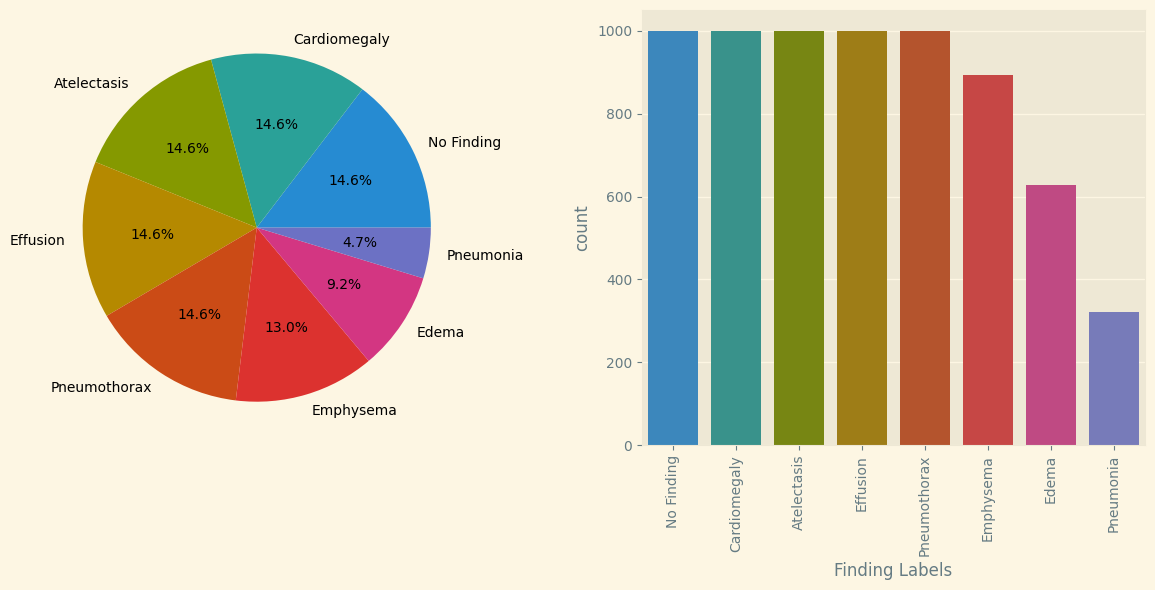

In [7]:
label_counts = df['Finding Labels'].value_counts()

plt.style.use('Solarize_Light2')

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.pie(df['Finding Labels'].value_counts(), labels=label_counts.index, autopct='%.1f%%')
# plt.legend()
plt.subplot(1,2,2)
sns.countplot(x=df['Finding Labels'], order= label_counts.index)
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()


**Train & Test Split**

In [8]:
df_train, df_test = train_test_split(df, test_size=0.2, shuffle=True, random_state=42)
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

**One Hot Encoding**

In [9]:
for col in df['Finding Labels'].unique():
    df_test[col] = np.where(df_test['Finding Labels'].str.contains(col), 1.0,0.0).astype('float32')
    df_train[col] = np.where(df_train['Finding Labels'].str.contains(col), 1.0,0.0).astype('float32')
TARGET = df_train.columns[-df['Finding Labels'].nunique():].tolist()

In [10]:
TARGET

['No Finding',
 'Cardiomegaly',
 'Edema',
 'Atelectasis',
 'Pneumonia',
 'Effusion',
 'Pneumothorax',
 'Emphysema']

In [11]:
!pip install -q -U segmentation_models

In [12]:
os.environ["SM_FRAMEWORK"] = 'tf.keras'
import segmentation_models

Segmentation Models: using `tf.keras` framework.


In [13]:
from segmentation_models import Unet
preprocess = segmentation_models.get_preprocessing('resnet18')

def build_fpn():
    
    fpn_model = Unet('resnet18', input_shape=(256,256,3), classes=1, activation='sigmoid')
    
    return fpn_model

In [14]:
import albumentations as albu

class MaskGenerator(tf.keras.utils.Sequence):
    def __init__(self, data, batch_size=16, shuffle=False, preprocess=None):
        self.data = data
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.preprocess = preprocess
        self.on_epoch_end()
        self.clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        
    def __len__(self):
        # Drop_Last = False
        return int(np.ceil(len(self.data) / self.batch_size))
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.data))
        if self.shuffle: np.random.shuffle(self.indexes)
            
    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        X = self.__data_generation(indexes)
        return X
    
    def __data_generation(self, indexes):    
        X = np.zeros((len(indexes),256,256,3), dtype='float32')
        
        for j,i in enumerate(indexes):
            ## Image
            row = self.data.iloc[i]
            path = row['path']
            img = Image.open(path).convert('L')
            img = img.resize((256,256), Image.Resampling.LANCZOS) # DownSampling
            img = np.array(img) # PIL Object -> np.array(uint8)
            img = self.clahe.apply(img)
            img = np.expand_dims(img, axis=-1)
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB) 
            
            X[j,] = img
            if self.preprocess != None: X = self.preprocess(X)
                
                
        return X

In [15]:
gen = MaskGenerator(df_train, batch_size=32, shuffle=False, preprocess=preprocess)

K.clear_session()
with strategy.scope(): fpn = build_fpn()
    
fpn.load_weights(f'{LOAD_SEGMENTATION_FROM}UNet_f0.weights.h5')
    
all_mask = fpn.predict(gen, verbose=1)

44920640/44920640 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
172/172 ━━━━━━━━━━━━━━━━━━━━ 179s 1s/step


In [16]:
all_mask = np.where(all_mask >= 0.5, 1, 0)
all_mask = (all_mask * 255).astype('uint8').squeeze()

all_mask = cv2.dilate(all_mask, None, iterations=2)
all_mask = cv2.erode(all_mask, None, iterations=1)

# <div style="padding: 25px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#A51C30"><b><span style='color:#A51C30'></span></b> <b>3. Build DataGenerator</b></div>

In [17]:
import albumentations as albu
print(albu.__version__)

1.4.14


In [18]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, data, mask, batch_size=16, shuffle=False, augment1=False, augment2=False, preprocess=None):
        super().__init__()
        self.data = data
        self.mask = mask
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augment1 = augment1
        self.augment2 = augment2
        self.on_epoch_end()
        self.preprocess = preprocess
        self.clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

        
    def __len__(self):
        
        # Drop_Last = False
        ct = int(np.ceil(len(self.data)/self.batch_size))
        return ct
    
    def __getitem__(self,index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        X, y = self.__data_generation(indexes)
        if self.preprocess != None: X = self.preprocess(X)
        if self.augment1: X = self.__augment1(X)
        if self.augment2: X = self.__augment2(X)
        return X,y
    
    def on_epoch_end(self,):
        self.indexes = np.arange(len(self.data))
        if self.shuffle: np.random.shuffle(self.indexes)
        
    def __data_generation(self, indexes):
        
        X = np.zeros((len(indexes),256,256,4), dtype='float32') 
        y = np.zeros((len(indexes),len(TARGET)), dtype='float32')
        
        for j,i in enumerate(indexes):
            row = self.data.iloc[i]
            path = row['path']
            
            img = Image.open(path).convert('L')  # Load image and convert to grayscale
            img = img.resize((256, 256), Image.Resampling.LANCZOS)  # Resize image
            img = np.array(img)  # Convert PIL image to numpy array
            
            
            img = self.clahe.apply(img)  # Apply CLAHE for contrast enhancement
            
            img = np.expand_dims(img, axis=-1)  # Expand dimensions to make it (H, W, 1)
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)  # Convert grayscale to RGB
        
            # FillNaN
            m = np.nanmean(img)
            img = np.nan_to_num(img, nan=m)   
            
            X[j,:,:,:3] = img
            X[j,:,:,3] = self.mask[i]
            
            y[j,] = row[TARGET]
            
        return X,y
            
    
    def __augment1(self, img_batch):
        
        composition = albu.Compose([
                 albu.HorizontalFlip(p=0.5),
        ])
        
        for i in range(img_batch.shape[0]):
            img = composition(image=img_batch[i,])['image']
            img_batch[i,] = img
            
        return img_batch
    
    
    def __augment2(self, img_batch,cutmix_prob=0.5, num_patches=2):
        batch_size, height, width, channels = img_batch.shape

        for i in range(batch_size):
            if np.random.rand() <= cutmix_prob:  
                for _ in range(num_patches):  # 여러 개의 패치를 적용하기 위해 반복문 추가
                    idx = np.random.randint(batch_size)
                    lam = np.random.beta(0.5, 0.5)
         
                    cut_width = min(int(width * lam), width//5)
                    cut_height = min(int(height * lam), height//5)
                    cut_x = np.random.randint(0, width - cut_width + 1)
                    cut_y = np.random.randint(0, height - cut_height + 1)

                    img_batch[i, cut_y:cut_y + cut_height, cut_x:cut_x + cut_width, :] = img_batch[idx, cut_y:cut_y + cut_height, cut_x:cut_x + cut_width, :]
            
        return img_batch

# <div style="padding: 25px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#A51C30"><b><span style='color:#A51C30'></span></b> <b>4. Build EfficientNet Model</b></div>

In [19]:
!pip install -q -U git+https://github.com/qubvel/efficientnet
    
import efficientnet.tfkeras as efn

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
segmentation-models 1.0.1 requires efficientnet==1.0.0, but you have efficientnet 1.1.1 which is incompatible.


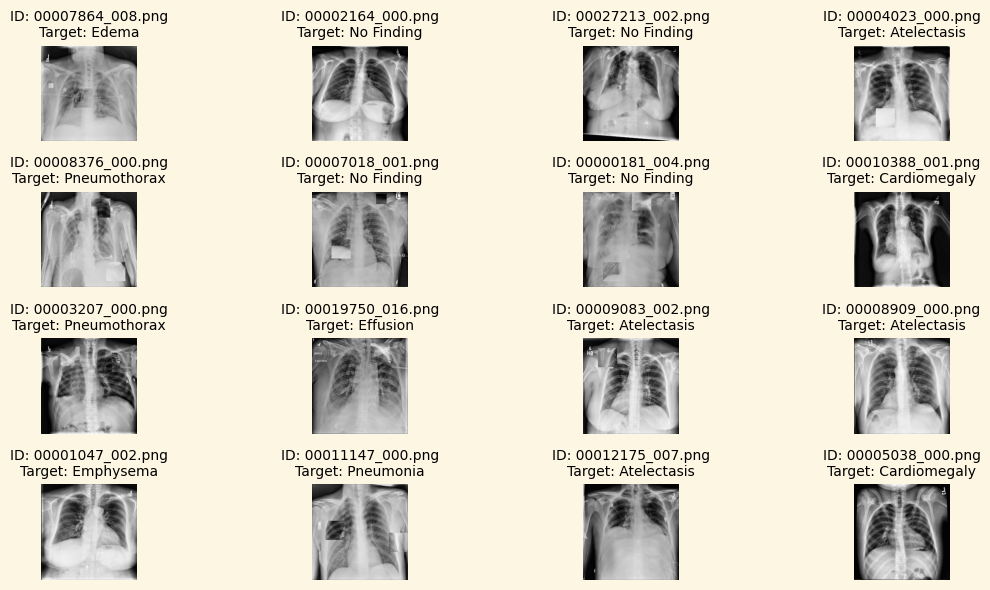

In [20]:
ROWS = 4; COLS = 4; BATCHES = 1


gen = DataGenerator(df_train, all_mask, batch_size=16, shuffle=False, augment1=True, augment2=True, preprocess=None)

for i, (x,y) in enumerate(gen):
    plt.figure(figsize=(12,6))
    for j in range(ROWS):
        for k in range(COLS):
            plt.subplot(ROWS, COLS, j*COLS+k+1)
            img_id = df_train.iloc[i*16+j*COLS+k]['Image Index']
            plt.title(f'ID: {img_id}\nTarget: {df_train.iloc[i*16+j*COLS+k]["Finding Labels"]}', size=10)
            img = x[j*COLS+k,:,:,:3]
            img = img.astype('uint8')
            plt.imshow(img)
            plt.axis('off')
    plt.tight_layout()
    plt.show()
    if i==BATCHES-1: break

In [21]:
def build_model():
    inp = layers.Input(shape=(256,256,4))
    base_model = efn.EfficientNetB0(include_top=False, weights=None, input_shape=(256,256,3))
    base_model.load_weights('/kaggle/input/tf-efficientnet-noisy-student-weights/efficientnet-b0_noisy-student_notop.h5')
    
    inp1 = inp[:,:,:,:3]
    inp2 = inp[:,:,:,3::4]
    
    x1 = base_model(inp1)
    x2 = layers.Resizing(8,8)(inp2)
    x2 = layers.Activation('sigmoid')(x2)
    
    x = layers.Multiply()([x1,x2])
    
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(len(TARGET), activation='sigmoid', dtype='float32')(x)
    
    # Compile
    model = Model(inputs=inp, outputs=x, name='efficientnet')
    loss = losses.BinaryCrossentropy(label_smoothing=0.05)
    opt = optimizers.Adam(learning_rate=1e-3)
    label_weights = [1.0] * 8
    AUC = tf.keras.metrics.AUC(name='auc', label_weights=label_weights)
    
    model.compile(loss=loss, optimizer=opt, metrics=[AUC])
    
    return model

In [22]:
from tensorflow.keras.utils import plot_model
K.clear_session()
model = build_model()
model.summary()

#plot_model(model, show_shapes=True, show_layer_names=True)

Model: "efficientnet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 256, 256,  │          0 │ input_layer[0][0] │
│ (GetItem)           │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 256, 256,  │          0 │ input_layer[0][0] │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resizing (Resizing) │ (None, 8, 8, 1)   │          0 │ get_item_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ efficientnet-b0     │ (None, 8, 8,      │  4,049,564 │ get_item[0][0]    │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 8, 8, 1)   │          0 │ resizing[0][0]    │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 8, 8,      │          0 │ efficientnet-b0[… │
│                     │ 1280)             │            │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ multiply[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 8)         │     10,248 │ global_average_p… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,059,812 (15.49 MB)

 Trainable params: 4,017,796 (15.33 MB)

 Non-trainable params: 42,016 (164.12 KB)

In [23]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping 

EPOCHS = 10

es = EarlyStopping(monitor='val_auc', mode='max', patience=5)
lr = ReduceLROnPlateau(monitor = 'val_auc', factor = 0.1, patience = 1, min_delta = 0.01,
                              mode='max',verbose=1)

# <div style="padding: 25px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#A51C30"><b><span style='color:#A51C30'></span></b> <b>5. Train CNN Model</b></div>

In [24]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for i, (_, valid_index) in enumerate(skf.split(df_train, df_train['Finding Labels'])):
    df_train.loc[valid_index, 'Fold'] = i

In [25]:
import tensorflow.keras.backend as K

all_oof = []
all_true = []
all_index = []
all_history = defaultdict(list)

for i in range(1):
    
    print('#'*25)
    print(f'### Fold {i+1}')
    
    train_gen = DataGenerator(df_train[df_train['Fold'] != i], all_mask[df_train['Fold'].values != i], shuffle=True, augment1=True, augment2=False, batch_size=16, preprocess=efn.preprocess_input)
    valid_gen = DataGenerator(df_train[df_train['Fold'] == i], all_mask[df_train['Fold'].values == i], shuffle=False, batch_size=32, preprocess=efn.preprocess_input)
    
    print(f'### train size {len(df_train[df_train["Fold"] != i])}, valid size {len(df_train[df_train["Fold"] == i])}')
    print('#'*25)
    
    K.clear_session()
    with strategy.scope():
        model = build_model()
    if LOAD_MODELS_FROM is None:
        history =  model.fit(train_gen, verbose=1,
              validation_data = valid_gen,
              epochs=EPOCHS, callbacks = [lr])
        model.save_weights(f'EffNet_f{i}.weights.h5')
        all_history['Train Loss'].append(history.history['loss'])
        all_history['Valid Loss'].append(history.history['val_loss'])
        all_history['Valid Auc'].append(history.history['val_auc'])
        all_history['Train Auc'].append(history.history['auc'])

    else:
        model.load_weights(f'{LOAD_MODELS_FROM}EffNet_f{i}.weights.h5')
        
    oof = model.predict(valid_gen, verbose=1)
    all_oof.append(oof)
    all_true.append(df_train[df_train['Fold'] == i][TARGET].values)
    all_index.append(df_train[df_train['Fold'] == i]['Image Index'].values)
    
    
    del model, oof, train_gen, valid_gen
    gc.collect()
    
all_oof = np.concatenate(all_oof)
all_true = np.concatenate(all_true)
all_index = np.concatenate(all_index)

#########################
### Fold 1
### train size 4378, valid size 1095
#########################
Epoch 1/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 300s 596ms/step - auc: 0.6410 - loss: 0.4222 - val_auc: 0.6936 - val_loss: 0.4387 - learning_rate: 0.0010
Epoch 2/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 156s 560ms/step - auc: 0.7697 - loss: 0.3655 - val_auc: 0.7254 - val_loss: 0.4523 - learning_rate: 0.0010
Epoch 3/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - auc: 0.8028 - loss: 0.3521
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
274/274 ━━━━━━━━━━━━━━━━━━━━ 154s 552ms/step - auc: 0.8028 - loss: 0.3522 - val_auc: 0.7249 - val_loss: 0.4113 - learning_rate: 0.0010
Epoch 4/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 155s 555ms/step - auc: 0.8452 - loss: 0.3309 - val_auc: 0.8449 - val_loss: 0.3361 - learning_rate: 1.0000e-04
Epoch 5/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step - auc: 0.8746 - loss: 0.3128
Epoch 5: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
274

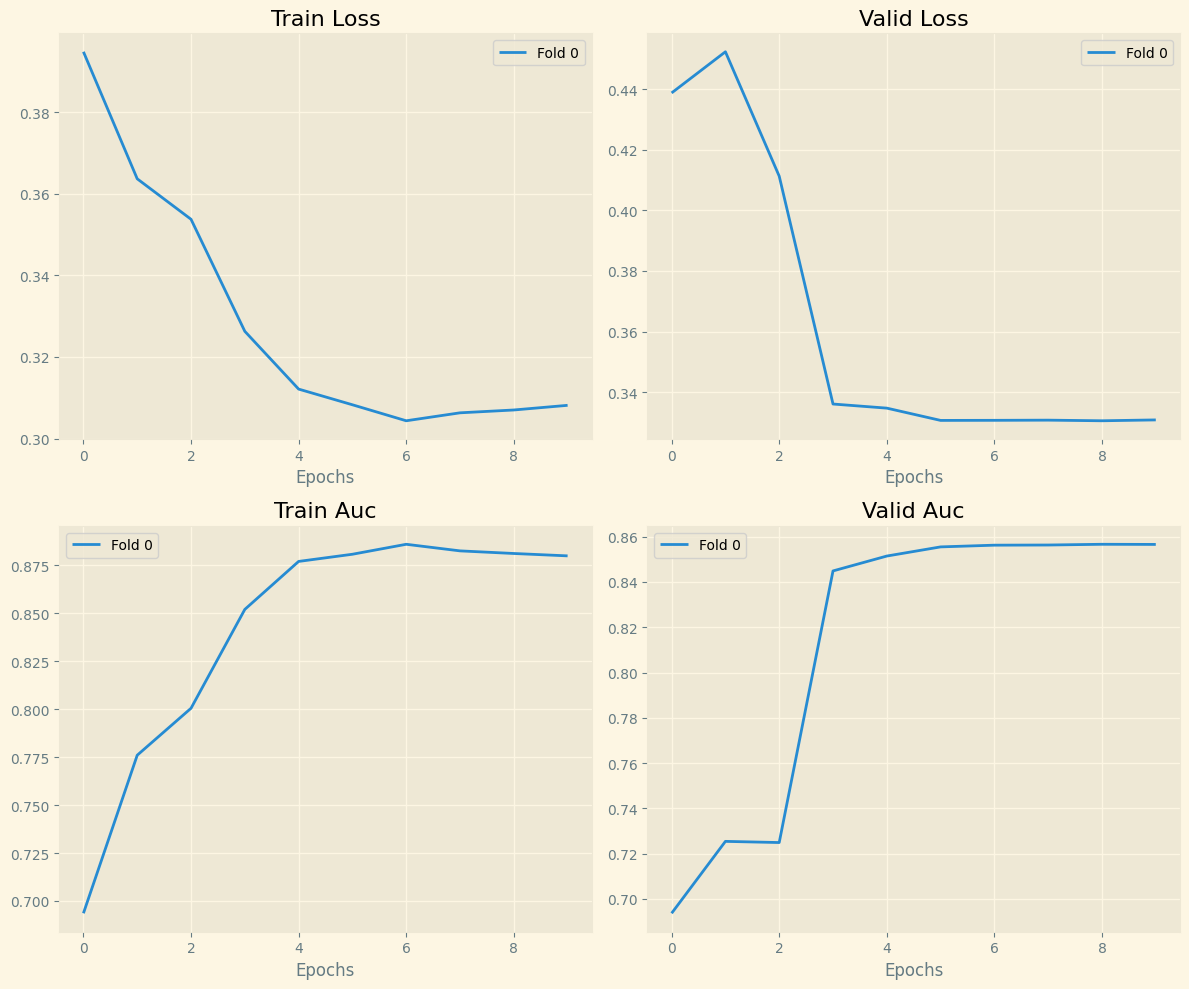

In [26]:
if LOAD_MODELS_FROM is None:
    plt.figure(figsize=(12,10))
    plt.subplot(2,2,1)
    plt.title('Train Loss')
    for fold, i in enumerate(all_history['Train Loss']):
        plt.plot(i, label=f'Fold {fold}')
        plt.xlabel('Epochs')
    plt.legend()

    plt.subplot(2,2,2)
    plt.title('Valid Loss')
    for fold, i in enumerate(all_history['Valid Loss']):
        plt.plot(i,label=f'Fold {fold}')
        plt.xlabel('Epochs')
    plt.legend()

    plt.subplot(2,2,3)
    plt.title('Train Auc')
    for fold, i in enumerate(all_history['Train Auc']):
        plt.plot(i, label=f'Fold {fold}')
        plt.xlabel('Epochs')
    plt.legend()
    
    plt.subplot(2,2,4)
    plt.title('Valid Auc')
    for fold, i in enumerate(all_history['Valid Auc']):
        plt.plot(i, label=f'Fold {fold}')
        plt.xlabel('Epochs')
    plt.legend()


    
    plt.tight_layout()
    plt.show()

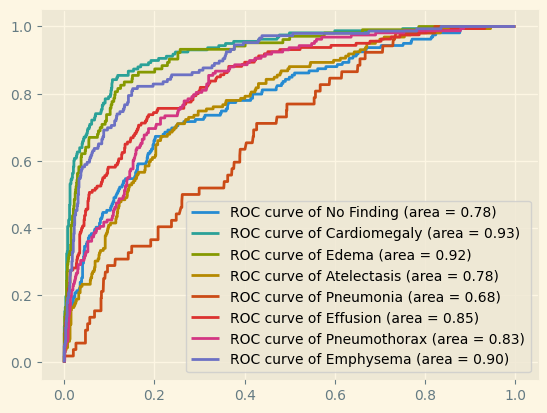

In [27]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(TARGET)):
    fpr[i], tpr[i], _ = roc_curve(all_true[:, i], all_oof[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# ROC 곡선 그리기
plt.figure()
for i in range(len(TARGET)):
    plt.plot(fpr[i], tpr[i], lw=2,
             label=f'ROC curve of {TARGET[i]} (area = {roc_auc[i]:0.2f})')
plt.legend()
plt.show()


In [28]:
auc_score = roc_auc_score(all_true, all_oof, average='macro', multi_class='ovr')  # 'ovr'은 one-vs-rest 방식
print('AUC for Train Set =', auc_score)

AUC for Train Set = 0.8327457996854828


# <div style="padding: 25px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#A51C30"><b><span style='color:#A51C30'></span></b> <b>7. Inference</b></div>

In [29]:
gen = MaskGenerator(df_test, batch_size=32, shuffle=False, preprocess=preprocess)

K.clear_session()
with strategy.scope(): fpn = build_fpn()
    
fpn.load_weights(f'{LOAD_SEGMENTATION_FROM}UNet_f0.weights.h5')
    
test_mask = fpn.predict(gen, verbose=1)

43/43 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step


In [30]:
test_mask = np.where(test_mask >= 0.5, 1, 0)
test_mask = (test_mask * 255).astype('uint8').squeeze()

test_mask = cv2.dilate(test_mask, None, iterations=2)
test_mask = cv2.erode(test_mask, None, iterations=1)

In [31]:
preds = []
model = build_model()

## No TTA
test_gen = DataGenerator(df_test, test_mask, shuffle=False, batch_size=64, preprocess=efn.preprocess_input)

for i in range(1):
    print(f'Fold {i+1}') 
    if LOAD_MODELS_FROM:
        model.load_weights(f'{LOAD_MODELS_FROM}EffNet_f{i}.weights.h5')
    else: 
        model.load_weights(f'EffNet_f{i}.weights.h5')
    
    pred = model.predict(test_gen, verbose=1) 
    
preds.append(pred)
pred_res = np.mean(preds,axis=0)
    

auc_score = roc_auc_score(df_test[TARGET], pred_res, average='macro', multi_class='ovr')  # 'ovr'은 one-vs-rest 방식
print('AUC for Test Set =', auc_score)

Fold 1


I0000 00:00:1726655203.663697      68 service.cc:145] XLA service 0x7cb3680497d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1726655203.663752      68 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1726655203.663756      68 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 1/22 ━━━━━━━━━━━━━━━━━━━━ 2:43 8s/step

I0000 00:00:1726655207.957425      68 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


22/22 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step
AUC for Test Set = 0.8334933822073134


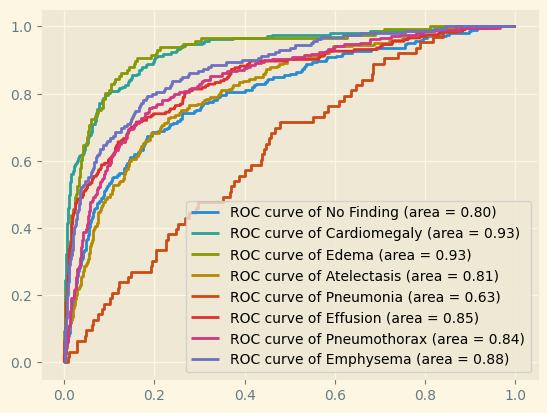

In [32]:
from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(TARGET)):
    fpr[i], tpr[i], _ = roc_curve(df_test[TARGET[i]], pred_res[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# ROC 곡선 그리기
plt.figure()
for i in range(len(TARGET)):
    plt.plot(fpr[i], tpr[i], lw=2,
             label=f'ROC curve of {TARGET[i]} (area = {roc_auc[i]:0.2f})')
plt.legend()
plt.show()